# TP4 : Mesure de la vitesse du son

## 1. Expérience
### Auteur : ARGUELLO Camilo et MASSEREY Romaine

### 1.0 Introduction


Dans ce travail, nous désirons mesurer la vitesse du son. Pour cela nous utiliserons le mode "Chronomètre sonore" de Phyphox.
Nous placerons deux téléphones espacés d'une distance d et nous allons ensuite produire deux bruits en tapant dans nos mains, l'un proche du téléphone 1 et l'autre du 2.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import qexpy as q
import qexpy.plotting as qplt
import scipy.stats as stats
from scipy.optimize import minimize

### 1 Mesure de la vitesse du son

#### Réalisation de l'expérience
Pour cette expérience, nous utiliserons l'application Phyphox qui nous permettra de mesurer le temps que met le son du clap pour aller d'un téléphone à un autre. Voilà donc les étapes pour réaliser ces mesures:

1. On place les téléphones à une distance d (parmis 0.5,1,2,3,4,5)
2. La première personne réalise un clap situé à une distance a du téléphone 1
3. La seconde personne réalise un deuxième clap à partir d'une distance b du téléphone 2.
4. On note les mesures affichées par chaque téléphone.

On obtient donc deux tableaux de la forme 6*10 soit 10 mesures pour les 6 distances.

#### 1.1 Questions préparatoires

Voici les grandeurs qu'on utilisera: $v$ la vitesse du son, $d$ la distance entre chaque téléphone, $a$ la distance entre le point d'origine du son 1 et le téléphone 1 et $b$ la distance entre le point d'origine du son 2 et le téléphone 2. On note qu'on choisit de réaliser les "claps" alignés aux deux téléphones (et non pas au-dessus) afin de pouvoir écrire: $a+d$ la distance du "clap" 1 au téléphone 2 et $b+d$ celle du "clap" 2 au téléphone 1. 

![Mesure clap](./assets/clap_mesures.jpg)

On définit donc $t_{1->1}$ et $t_{1->2}$ les temps d'arrivés du "clap 1" sur le téléphone 1 et 2 ainsi que $t_{2->1}$ et $t_{2->2}$ pour le "clap 2". 

On a alors: $\Delta t_1 = t_{2->1}-t_{1->1}$ et $\Delta t_2 = t_{2->2}-t_{1->2}$ les intervalles de temps mesuré par chaque téléphone.


On peut donc écrire: $$\Delta t_1 = \frac{b+d}{v} - \frac{a}{v} = \frac{b-a+d}{v}$$ et $$\Delta t_2 = \frac{b}{v} - \frac{a+d}{v} = \frac{b-a-d}{v}.$$
On a alors:$\Delta t_1 - \Delta t_2 = \frac{2d}{v}.$

Ainsi, pour trouver la vitesse du son en fonction de $\Delta t_1$ et $\Delta t_2$, on écrira simplement:$$v=\frac{2d}{\Delta t_1 - \Delta t_2} .$$

Comme on l'a expliqué plus haut, il vaut mieux de faire les bruits dans l'alignement des deux téléphones afin d'avoir les distances a,b et d sur une ligne. Si on les faisait au-dessus,on aurait des angles droits.




#### 1.2 Estimation des erreurs

Dans cette partie, nous cherchons à estimer les erreurs dûes à:
* la position du capteur
* la mesure de la distance entre les deux capteurs
* le temps de vol du son entre les deux téléphones.

L'estimation de l'erreur sur la position du capteur de son sur chacun des téléphones dépend de plusieurs facteurs, tels que la précision de la calibration du capteur, la qualité de la conception du téléphone et la stabilité de la fixation du capteur. Nous pouvons donc dire que pour les téléphones modernes, on peut estimer une erreur de position du capteur de son de l'ordre de quelques millimètres.


In [2]:
def calculate_uncertainty (hs):
    """
    Cette fonction calcule l'incertitude sur la moyenne d'une série de mesures
    """
    avg = np.mean(hs)
    std = np.std(hs) 
    dx = std / np.sqrt(len(hs))
    dh = np.sqrt(dx**2 + dx**2)
    return avg, dh

In [3]:
# Pour chaque distance, on a mesuré 2 fois
distance_a = np.array([10.0, 10.2]) # cm
distance_b = np.array([10.0, 10.1]) # cm
distance_d = np.array([50, 48.1]) # cm

avg_a, dh_a = calculate_uncertainty(distance_a)
avg_b, dh_b = calculate_uncertainty(distance_b)
avg_d, dh_d = calculate_uncertainty(distance_d)

print("Distance a = {:.2f} +/- {:.2f} cm".format(avg_a, dh_a))
print("Distance b = {:.2f} +/- {:.2f} cm".format(avg_b, dh_b))
print("Distance d = {:.2f} +/- {:.2f} cm".format(avg_d, dh_d))

total_distance = avg_a + avg_b + avg_d
total_distance_error = np.sqrt(dh_a**2 + dh_b**2 + dh_d**2)

print("Total Distance = {:.2f} +/- {:.2f} cm".format(total_distance, total_distance_error))

Distance a = 10.10 +/- 0.10 cm
Distance b = 10.05 +/- 0.05 cm
Distance d = 49.05 +/- 0.95 cm
Total Distance = 69.20 +/- 0.96 cm


Ainsi, on peut estimer l'erreur sur le temps de vol du son entre les deux téléphones. Dans ce cas, nous mesurons 3 fois à une distance de 0,5 m. 

In [4]:
data_phone_1_m1 = pd.read_csv("mesures/telephone1-m1/All.csv", sep=',', skiprows=0)
data_phone_1_m2 = pd.read_csv("mesures/telephone1-m2/All.csv", sep=',', skiprows=0)
data_phone_1_m3 = pd.read_csv("mesures/telephone1-m3/All.csv", sep=',', skiprows=0)

data_phone_2_m1 = pd.read_csv("mesures/telephone2-m1/All.csv", sep=',', skiprows=0)
data_phone_2_m2 = pd.read_csv("mesures/telephone2-m2/All.csv", sep=',', skiprows=0)
data_phone_2_m3 = pd.read_csv("mesures/telephone2-m3/All.csv", sep=',', skiprows=0)

In [5]:
# Pour calculer l'erreur sur le temps
# On prend les valeurs Delta t pour chaque clap
# Clap 1
# Valeurs de clap 1 pour le téléphone 1 et 2
# The nomeclature is e_{experiment number}_all_intervals_clap{clap number}
e_1_all_intervals_clap1 = pd.concat([data_phone_1_m1["Interval (s)"][:1],data_phone_2_m1["Interval (s)"][:1]])
e_1_all_intervals_clap2 = pd.concat([data_phone_1_m1["Interval (s)"][1:2],data_phone_2_m1["Interval (s)"][1:2]])

# Clap 2
e_2_all_intervals_clap1 = pd.concat([data_phone_1_m2["Interval (s)"][:1],data_phone_2_m2["Interval (s)"][:1]])
e_2_all_intervals_clap2 = pd.concat([data_phone_1_m2["Interval (s)"][1:2],data_phone_2_m2["Interval (s)"][1:2]])

# Clap 3
e_3_all_intervals_clap1 = pd.concat([data_phone_1_m3["Interval (s)"][:1],data_phone_2_m3["Interval (s)"][:1]])
e_3_all_intervals_clap2 = pd.concat([data_phone_1_m3["Interval (s)"][1:2],data_phone_2_m3["Interval (s)"][1:2]])


In [6]:
# Valeurs moyennes pour les claps
clap1_avg_times = [
    calculate_uncertainty(e_1_all_intervals_clap1)[0],
    calculate_uncertainty(e_2_all_intervals_clap1)[0],
    calculate_uncertainty(e_3_all_intervals_clap1)[0]
]
clap2_avg_times = [
    calculate_uncertainty(e_1_all_intervals_clap2)[0],
    calculate_uncertainty(e_2_all_intervals_clap2)[0],
    calculate_uncertainty(e_3_all_intervals_clap2)[0]
]

# Erreurs pour les claps
clap1_errors = [
    calculate_uncertainty(e_1_all_intervals_clap1)[1],
    calculate_uncertainty(e_2_all_intervals_clap1)[1],
    calculate_uncertainty(e_3_all_intervals_clap1)[1]
]
clap2_errors = [
    calculate_uncertainty(e_1_all_intervals_clap2)[1],
    calculate_uncertainty(e_2_all_intervals_clap2)[1],
    calculate_uncertainty(e_3_all_intervals_clap2)[1]
]
# Temps total pour chaque clap
clap1_total_time = sum(clap1_avg_times)
clap2_total_time = sum(clap2_avg_times)

# Erreur totale pour chaque clap
clap1_total_error = np.sqrt(sum([err**2 for err in clap1_errors]))
clap2_total_error = np.sqrt(sum([err**2 for err in clap2_errors]))

# Print the results
print("Temps total pour le clap 1 = {:.2f} +/- {:.2f} s".format(clap1_total_time, clap1_total_error))
print("Temps total pour le clap 2 = {:.2f} +/- {:.2f} s".format(clap2_total_time, clap2_total_error))

Temps total pour le clap 1 = 1.47 +/- 0.01 s
Temps total pour le clap 2 = 1.23 +/- 0.03 s


La mesure est donc relativement précise pour chaque clap. On peut donc aussi confirmer que l'erreur sur le temps de vol du son entre les deux téléphones est de l'ordre de quelques millisecondes.

#### 1.3 Prise de données

##### Mode opératoire

Pour cette expérience, nous utiliserons l'application Phyphox qui nous permettra de mesurer le temps que met le son du clap pour aller d'un téléphone à un autre. Voilà donc les étapes pour réaliser ces mesures:

1. On place les téléphones à une distance $d$ (parmis 0.5,1,2,3,4,5)
2. La première personne réalise un clap situé à une distance $a$ du téléphone 1
3. La seconde personne réalise un deuxième clap à partir d'une distance $b$ du téléphone 2.
4. On note les mesures affichées par chaque téléphone.

On obtient donc deux tableaux de la forme `6*10` soient 10 mesures pour les 6 distances.

In [7]:
distances = np.array([0.5, 1, 2, 3, 4, 5]) # Liste des distances en mètres

#Pour d = 0.5 m

t1d = np.array([2.936, 1.719, 0.962, 2.014, 1.925, 1.991, 1.723, 1.367, 1.542, 2.014]) #[s]
t2d = np.array([2.934, 1.722, 0.959, 2.011, 1.922, 1.988, 1.719, 1.364, 1.539, 2.011]) #[s]

#Pour d = 1 m

t1d1 = np.array([1.666, 1.336, 2.171, 1.782, 1.675 , 1.705, 1.765, 1.472, 1.720, 1.555]) #[s]
t2d1 = np.array([1.662, 1.330, 2.166, 1.777, 1.669 , 1.698, 1.755, 1.467, 1.714, 1.549]) #[s]

#Pour d = 2 m

t1d2 = np.array([1.510, 1.545,1.537 , 1.970, 1.203, 1.550, 1.314, 1.189, 1.482, 1.389]) #[s]
t2d2 = np.array([1.500, 1.532, 1.526,1.958, 1.190, 1.538, 1.302, 1.178, 1.469, 1.377]) #[s]

#Pour d = 3 m

t1d3 = np.array([1.334, 1.318, 1.672, 1.610, 1.571, 1.100, 1.526, 1.129, 1.497 , 1.072]) #[s]
t2d3 = np.array([1.315 , 1.301, 1.665, 1.593, 1.554, 1.083, 1.509, 1.111, 1.479, 1.055]) #[s]

#Pour d = 4m

t1d4 = np.array([1.225, 1.371, 0.929, 0.908, 1.526, 1.215, 1.192, 0.923, 1.150, 1.086]) #[s]
t2d4 = np.array([1.202, 1.351, 0.905, 0.883, 1.492, 1.192, 1.170, 0.898, 1.127, 1.064]) #[s]

#Pour d = 5 m

t1d5 = np.array([1.070, 1.205, 1.067, 1.093, 1.117, 1.410, 1.004, 1.312, 1.284, 1.316]) #[s]
t2d5 = np.array([1.039, 1.176, 1.037, 1.063, 1.086, 1.378, 0.974, 1.282, 1.256, 1.284]) #[s]

In [8]:
num_measurements = 10  # Nombre de mesures pour chaque distance

temps_phone_1 = np.array([
   t1d,
   t1d1, 
   t1d2,
   t1d3,
   t1d4,
   t1d5
])

temps_phone_2 = np.array([
    t2d,
    t2d1,
    t2d2,
    t2d3,
    t2d4,
    t2d5
])

print(temps_phone_1.shape)
print(temps_phone_2.shape)

(6, 10)
(6, 10)


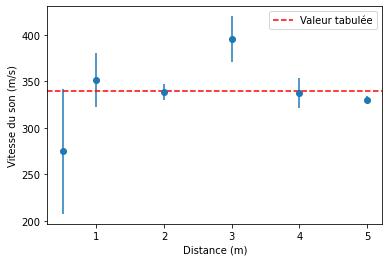

Vitesse moyenne du son : 338.2 m/s
Erreur associée : 24.93
Valeur tabulée : 340 m/s


In [28]:

# Tableau 2D pour stocker les mesures de temps
time_measurements = temps_phone_1 - temps_phone_2

# Calcul de ∆t2 - ∆t1 et de l'erreur associée
mean_differences = np.mean(time_measurements, axis=1)
error_differences = np.std(time_measurements, axis=1) / np.sqrt(num_measurements)

# Calcul de la vitesse du son v et propagation des erreurs
speed_of_sound = []
error_speed_of_sound = []

for i, distance in enumerate(distances):
    speed = []
    for mesure in time_measurements[i]:
        speed2 = 2 * distance / mesure
        speed.append(speed2)

    error_distance = 0.01  # Supposons une erreur de 1 cm sur la distance d
    error_speed = np.mean(speed) * np.sqrt((error_distance / distance)**2 + (error_differences[i] / mean_differences[i])**2)
    
    speed_of_sound.append(np.mean(speed))
    error_speed_of_sound.append(error_speed)


# plot distance et speed_of_sound
# Tracé de la vitesse du son en fonction de la distance
plt.errorbar(distances, speed_of_sound, yerr=error_speed_of_sound, fmt='o')
plt.axhline(y=340, color='r', linestyle='--', label='Valeur tabulée')
plt.xlabel('Distance (m)')
plt.ylabel('Vitesse du son (m/s)')
plt.legend()
plt.show()

# Calcul de la vitesse moyenne du son et de l'erreur associée
mean_speed_of_sound = np.mean(speed_of_sound)
error_mean_speed_of_sound = np.mean(error_speed_of_sound)

print("Vitesse moyenne du son : {:.4} m/s".format(mean_speed_of_sound))
print("Erreur associée : {:.4}".format(error_mean_speed_of_sound))
print("Valeur tabulée :", 340, "m/s")

A partir des données prises en réalisant l'expérience, nous avons pu réaliser un graphe illustrant la vitesse du son calculée à partir des temps mesurés en fonction de la distance entre les téléphones. 

Nous observons ici que les vitesses expérimentales correspondent plutôt bien à la valeur réelle puisqu'on a $338\ m/s$ comme vitesse moyenne de son (ce qui est quand même proche de $340 \ m/s$).

On voit aussi sur ce graphe que les erreurs sur les temps sont plus importants que les erreurs sur la distance.

## 1.4 Ajustement de modèle

### Minimisation numérique de $\chi ^2$

Nous cherchons maintenant à créer une fonction qui calcule le $\chi ^2$ en fonction de la vitesse et de visualiser sur une courbe $\chi ^2 (v)$.

Comme on peut le voir ci-dessous, cette courbe prend la forme d'une parabole. On note aussi qu'on obtiens un $\chi ^2$ de $336$  $m/s$ alors que la vitesse calculée précedemment expérimentalement était de $338$ $m/s$. On peut donc dire que le modèle est satisfaisant.

Visuellement, la valeur de $v$ qui minimise le $\chi ^2$ est de $339$ $m/s.$

On a aussi calculé cette valeur à l'aide d'un algorithme et on obtient: $340$ $m/s$ ce qui correspond complètement à la valeur exacte!! La minimisation est dobc très efficace ici.

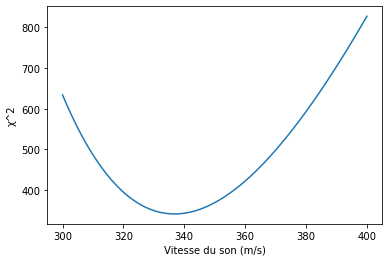

Valeur minimale approximative de χ^2 : 340.9 m/s
Valeur de v associée à χ^2 minimale : 336.4 m/s


In [69]:
num_measurements = len(time_measurements[0])  # Nombre de mesures pour chaque distance

def chi_squared(v):
    chi_squared = 0
    for i in range(len(distances)):
        chi_squared += np.sum(((time_measurements[i] - (2 *distances[i] / v))**2 / 0.001**2))
    return chi_squared

# Tracé de χ^2 en fonction de v
v_values = np.linspace(300, 400, 100)  # Plage de valeurs pour v
chi_squared_values = np.array([chi_squared(v) for v in v_values])

plt.plot(v_values, chi_squared_values)
plt.xlabel('Vitesse du son (m/s)')
plt.ylabel('χ^2')
plt.show()

# Détermination de la valeur minimale approximative de χ^2
min_chi_squared_index = np.argmin(chi_squared_values)
min_chi_squared_v = v_values[min_chi_squared_index]
min_chi_squared = chi_squared_values[min_chi_squared_index]

print("Valeur minimale approximative de χ^2 : {:.4} m/s".format(min_chi_squared))
print("Valeur de v associée à χ^2 minimale : {:.4} m/s".format(min_chi_squared_v))

### Méthode analytique par minimisation du $\chi ^2$

D'après l'expression:

$$ v = \frac{2d}{\Delta t_1 - \Delta t_2} $$

On peut dire que existe une relation linéaire entre $v$ et $\Delta t_1 - \Delta t_2$. Alors, maintenant on peut chercher une valeur de $v$ qui minimise $\chi ^2$.

On a donc:

$$ f(x) = a x $$ 

On peut donc calculer $a$:

$$ A = \sum_{i=1}^{n} \frac{x_i y_i}{\sigma_i^2}, \ B = \sum_{i=1}^{n} \frac{x_i^2}{\sigma _i^2}, \ C = \sum_{i=1}^{n} \frac{x_i}{\sigma _i^2}, \ D = \sum_{i=1}^{n} \frac{y_i}{\sigma _i^2}, \ E = \sum_{i=1}^{n} \frac{1}{\sigma _i^2} $$

$$ \hat{a} = \frac{AE-DC}{BE-C^2} $$

Et après simplification:

$$ \hat{a} = \frac{A}{B} $$


In [123]:
# Calcul du χ² (analytique) en fonction de temps

A = 0
B = 0

for i,d in enumerate(distances):
    A += np.sum(d * time_measurements[i] / 0.001**2)
    B += np.sum(d**2 / 0.001**2)

a = A / B

print("Paramètre a = {:.3}".format(a))

Paramètre a = 0.0594


#### Ajustement par QExPy

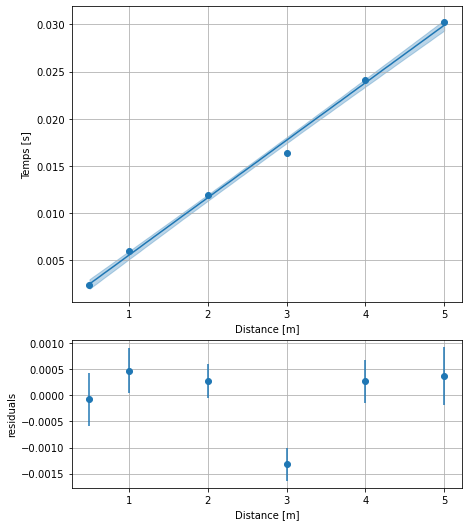

----------------- Fit Results -------------------
Fit of first to linear

Result Parameter List: 
slope = 0.0061 +/- 0.0002,
intercept = -0.0006 +/- 0.0006

Correlation Matrix: 
[[ 1.    -0.851]
 [-0.851  1.   ]]

chi2/ndof = 0.00/3

--------------- End Fit Results -----------------
Valeur de a : 0.006099


In [124]:
# Calcul des moyennes et erreurs
mean_differences = q.MeasurementArray(np.mean(time_measurements, axis=1), unit='s', name='Temps moyen')
error_differences = q.MeasurementArray(np.std(time_measurements, axis=1) / 0.001**2, unit='s', name='Incertitude')

distances_q = q.MeasurementArray(distances, unit='m', name='Distance')
mean_differences_q = q.MeasurementArray(mean_differences)
error_differences_q = q.MeasurementArray(error_differences)

figure = qplt.plot(
    xdata=distances_q,
    ydata=mean_differences_q,
    yerror=error_differences_q,
    name="first")

resultats = figure.fit(model=q.FitModel.LINEAR)
a_qexpy = resultats.params[0].value # extraction de a
figure.error_bars()
figure.residuals()
figure.xname = 'Distance '
figure.yname = 'Temps '
figure.show()

print(resultats)
print("Valeur de a : {:.4}".format(a_qexpy))

### Conclusion

Dans cette expérience o a mesuré la vitesse du son, nous avons utilisé l'application Phyphox et avons réalisé des mesures des temps de claps.

Les résultats expérimentaux ont montré que les vitesses mesurées correspondaient assez bien à la valeur réelle, avec une vitesse moyenne du son de 338 m/s, qui est proche de la valeur attendue de 340 m/s.